# Data_transformation

In [1]:
import pandas as pd
import numpy as np
from itertools import islice


speed_avg=[]
rpm_avg=[]
mileage=[]
distance=[]
fuel_total=[]
engine_torque=[]

#File Reading
data=pd.read_csv('internal_data.csv')

#Removing Outlier
cleaned_pat_data=data.loc[data['AFE']!=data['AFE'].max()]
cleaned_pat_data['AFE']=cleaned_pat_data['AFE'].astype('str')

#selecting required_data
pattern_data=cleaned_pat_data[['AFE','T','TFC','RPM','CSP','ANR','ODO']]

#removing negative Torque
pattern_data=pattern_data[pattern_data['ANR']>0].reset_index(drop=True)

#getting actually distance
pattern_data['ODO']=pattern_data['ODO']-pattern_data['ODO'][0]

#removing null records from data
ind_mileage_without_null=pattern_data.index[pattern_data['AFE']!='nan'].tolist()

#saving modified data
pattern_data['AFE']=pattern_data['AFE'].astype('float')
pattern_data.to_csv('pattern_data.csv')

final_mileage_ind=[2]
ll=[0]

#getting index for slicing
try:
    for ss in range(1,len(ind_mileage_without_null)):
        #print(ind_mileage_without_null[ss]-ind_mileage_without_null[ss+1])
        if abs(ind_mileage_without_null[ss]-ind_mileage_without_null[ss+1]) >1:
            if ll[-1]==ind_mileage_without_null[ss]:
                #final_mileage_ind.append(ind_mileage_without_null[ss])
                final_mileage_ind.append(ind_mileage_without_null[ss]+1)
            else:
                final_mileage_ind.append(ind_mileage_without_null[ss])
                final_mileage_ind.append(ind_mileage_without_null[ss]+1)
        else:
                final_mileage_ind.append(ind_mileage_without_null[ss])
                ll.append(ind_mileage_without_null[ss]+1)
except Exception:
    print('eeror')
     

final_mileage_ind=sorted(list(set(final_mileage_ind[:])-set(ll[1:])))

#print(len(final_mileage_ind[:-1]))

length_to_split=[2 for ss in range(0,round((int(len(final_mileage_ind[:-1])))/2))]

#print((len(final_mileage_ind)-1)/2)

#print(len(length_to_split))
input=iter(final_mileage_ind)
final_mileage_ind_split=[list(islice(input, elem)) for elem in length_to_split]
#print(ind_mileage_without_null[:40])
#print(ll)

speed_avg.append(pattern_data['CSP'][ind_mileage_without_null[0]])
rpm_avg.append(pattern_data['RPM'][ind_mileage_without_null[0]])
distance.append(pattern_data['ODO'][ind_mileage_without_null[0]])
mileage.append(pattern_data['AFE'][ind_mileage_without_null[0]])
fuel_total.append(pattern_data['TFC'][ind_mileage_without_null[0]])
engine_torque.append(pattern_data['ANR'][ind_mileage_without_null[0]])

#print(final_mileage_ind)
for ss in final_mileage_ind_split:
    if 11491 in ss:
        print('14681',ss,pattern_data['CSP'][ss[0]:ss[1]+1].mean()) #
    if 14710 in ss:
        print('14710',pattern_data['CSP'][ss[0]:ss[1]+1].mean())
    
    speed_avg.append(pattern_data['CSP'][ss[0]:ss[1]+1].mean())
    rpm_avg.append(pattern_data['RPM'][ss[0]:ss[1]+1].mean())
    distance.append(pattern_data['ODO'][ss[0]:ss[1]+1].sum())
    fuel_total.append(pattern_data['TFC'][ss[0]:ss[1]+1].sum())
    engine_torque.append(pattern_data['ANR'][ss[0]:ss[1]+1].mean())
    mileage.append(pattern_data['AFE'][ss[1]])
    
for kk in ll[1:]:
    speed_avg.append(pattern_data['CSP'][kk])
    mileage.append(pattern_data['AFE'][kk])
    rpm_avg.append(pattern_data['RPM'][kk])
    fuel_total.append(pattern_data['TFC'][kk])
    distance.append(pattern_data['ODO'][kk])
    engine_torque.append(pattern_data['ANR'][kk])

pattern_use=pd.DataFrame(list(zip(mileage[:],speed_avg[:],rpm_avg[:],distance[:],fuel_total[:],engine_torque[:])),columns=['mileage','speed_avg', 'rpm_avg','distance_total','fule_total','torque_avg'])
pattern_use.to_csv('consolidation_speed_avg_mileage.csv')

group=pattern_use.groupby('mileage')
maxx=group.max()
maxx.to_csv('delet.csv')
#print(final_mileage_ind_split[:5])


<ipython-input-1-2c830236c908>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_pat_data['AFE']=cleaned_pat_data['AFE'].astype('str')


eeror
14681 [11406, 11491] 47.03034883720932


# Visualization of mileage across speed,distance,fuel and torque

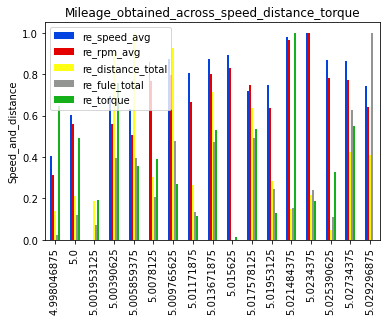

In [2]:
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
# Some boilerplate to initialise things
scaler = MinMaxScaler()
scaler_1= StandardScaler()

df=pd.read_csv('delet.csv')
df[['re_speed_avg','re_rpm_avg','re_distance_total','re_fule_total','re_torque']]= scaler.fit_transform(
   df[["speed_avg", "rpm_avg",'distance_total','fule_total','torque_avg']])
visual_data=df[['mileage','re_speed_avg','re_rpm_avg','re_distance_total','re_fule_total','re_torque']]


visual_data.to_csv('normalised_data_of_max.csv')

    

cmap = ListedColormap(['#0343df', '#e50000', '#ffff14','#929591','#15B01A'])

ax = visual_data.plot.bar(x='mileage', colormap=cmap)

ax.set_xlabel(None)
ax.set_ylabel('Speed_and_distance')
ax.set_title('Mileage_obtained_across_speed_distance_torque')

plt.show()


#  XGBoost Machine Learning model traning and prediction on test data

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.metrics import explained_variance_score, r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score
import seaborn as sb

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')


data = pd.read_csv('consolidation_speed_avg_mileage.csv')
data=data[['mileage','speed_avg','rpm_avg','distance_total','torque_avg']]
data.dropna(axis=0, subset=['mileage'], inplace=True)


y = data.mileage
X = data.drop(['mileage'], axis=1).select_dtypes(exclude=['object'])
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25)

#my_imputer = imputer()
train_X = imputer.fit_transform(train_X)
test_X = imputer.transform(test_X)

pd.DataFrame(train_X).to_csv('train_x.csv')
pd.DataFrame(test_X).to_csv('test_x.csv')


my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(train_X, train_y, early_stopping_rounds=5, 
             eval_set=[(test_X, test_y)], verbose=False)


predictions = my_model.predict(test_X)
data_result=pd.DataFrame(list(zip(test_y.to_list(),list(predictions))),columns=['actual_mileage','predicted_mileage'])
data_result.to_csv('mileage_prediction_result.csv')

#print(list(predictions),'oringinal',test_y.to_list())

variance_scores=explained_variance_score(predictions,test_y)
absolute_mean_errors=mean_absolute_error(test_y,predictions)
mean_squared_errors=mean_squared_error(test_y,predictions,squared=True)



#print('mean_square_error_of random_forest',mean_squared_errors,'random_forest_variance',
#variance_scores,'random_forest_abs_mean_error',absolute_mean_errors)

print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))



Mean Absolute Error : 0.004861683681093413


# Visualization of comparsion between actual and predicted mileage

# predicted mileage value

In [16]:
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt 
import plotly.express as px

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

data=pd.read_csv('prediction_visualize.csv')
data_act=data[['speed_1', 'actual_mileage_1']]
data_act['class']='act'
data_act=data_act.rename(columns={'actual_mileage_1':'act_pre'})
data_pre=data[['speed_1','predicted_mileage_1']]
data_pre['class']='pre'
data_pre=data_pre.rename(columns={'predicted_mileage_1':'act_pre'})
frame=[data_pre,data_act]
result = pd.concat(frame)
#print(result.tail(10))
#data_2=pd.read_csv('test_x.csv')
#frame=[data,data_2]
#data_3=pd.concat(frame,axis=1)
#data_3[['speed_1','actual_mileage_1','predicted_mileage_1']]=scaler.fit_transform(data_3[['speed','actual_mileage','predicted_mileage']])
#data_3.to_csv('prediction_visualize.csv')
fig = px.scatter(result, x="speed_1", y="act_pre", marginal_y="violin",color='class',
           marginal_x="box", trendline="ols", template="simple_white")


#'actual_mileage'
#'predicted_mileage'
fig.show()

In [ ]:
sb.lmplot(x = 'speed_1',
            y = 'predicted_mileage_1', 
            ci = None,
            data = data)

# actual mileage value

In [ ]:
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

data=pd.read_csv('prediction_visualize.csv')

#data_2=pd.read_csv('test_x.csv')
#frame=[data,data_2]
#data_3=pd.concat(frame,axis=1)
#data_3[['speed_1','actual_mileage_1','predicted_mileage_1']]=scaler.fit_transform(data_3[['speed','actual_mileage','predicted_mileage']])
#data_3.to_csv('prediction_visualize.csv')


sb.lmplot(x = 'speed_1',
            y = 'actual_mileage_1', 
            ci = None,
            data = data)
#'actual_mileage'
#'predicted_mileage'
plt.show()




